# The story of OBSID 21842

aka

**This is why we should not casually _repair_ bias files** 

    K.J. Glotfelty


### Disclaimer

Okay, my disapproval of the mucking with the bias files is well documented.  To be clear,
I think it's a **horrible** idea, but I also realize I am alone tilting at this particular windmill. 
I make no excuse for the biases (no pun intended) littered throughout this doc.

All opinions are my own and do not represent and official recommendation from SDS. 


## Introduction 

    From: Operators 
    Date: Thu, 27 Sep 2018 09:55:37 -0400

    ...
    we have a question about obsid 21842.

    This obsid has a broad, bright streak in the level 1 event data. The streak
    had been successfully removed in level 2 data as the pixels were assigned a
    bad pixel status in the evt1. We asked the ACIS people to investigate the
    origin of this streak and they said it is an artifact due to an unusual low
    region in the bias (in chip 1) and suggested to repair the bias.

    We repaired the bias file and we see that the feature in the level 1 data
    can now be filtered out by removing all the pixels with PHAS(1,1)<40 (as
    suggested by ACIS people). However, this feature is now visible in the
    level 2 data while it was not before (although not as bright as in the
    level 1 data). Not all the pixels in the feature in the new evt1 are
    assigned a bad pixel status. Filtering the new evt2 file and removing
    pixels with PHA<40, successfully remove the feature in the evt2 as well.

    We would like to understand how the software is behaving in this unusual
    case and therefore we ask if you could have a look at it. 
    ...
    

## Examine the original processing

We begin by examining the pipeline processing with the on-orbit bias.

### Level 1 Event file

Let's start by taking a look at the L1 event file

In [1]:
#data are proprietary 
umask 077

In [2]:
evt1=21842/secondary/acisf21842_000N001_evt1.fits

In [3]:
skyreg='rotbox(3330.5,4072.5,300,100,49.0)'

In [4]:
hiddenreg="physical;polygon(4530.5,5390.5,5074.5,4158.5,5286.5,3750.5,3646.5,2826.5,3294.5,3558.5,3498.5,3722.5,3658.5,4146.5,3414.5,4854.5) # fill=1 color=grey"

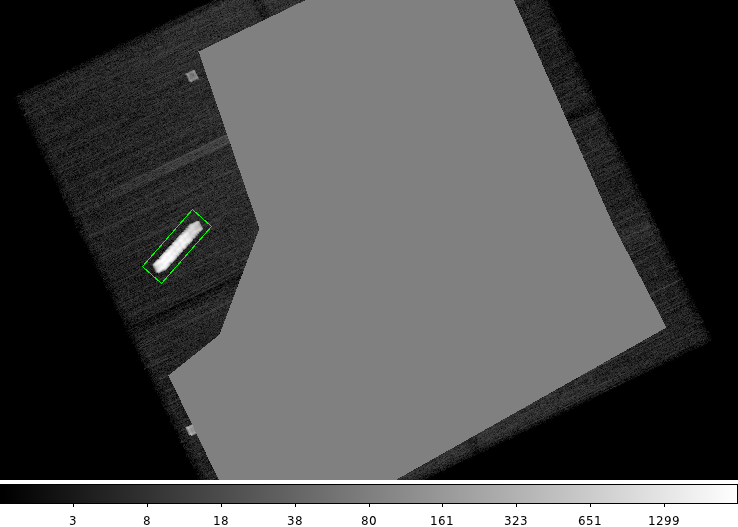

In [5]:
ds9 $evt1 -scale log -bin factor 4 \
  -regions command "physical;${skyreg}" \
  -regions command "${hiddenreg}" \
  -saveimage png ds9_01_evt1_skycoords.png -quit

display < ds9_01_evt1_skycoords.png

we see the bright set of bad pixels reported in `ascds_help` email.  I've drawn a rough outline around the anomaly (just by eye).

### Level 2 event file

Looking at the Level 2 event file

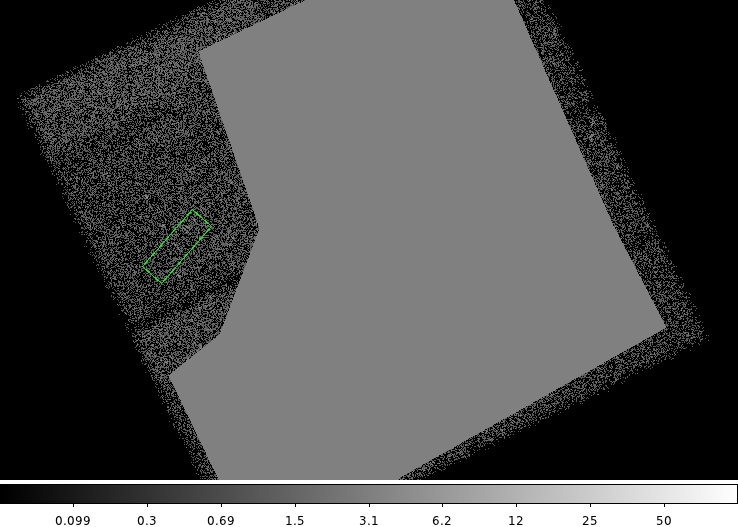

In [6]:
evt2=21842/primary/acisf21842N001_evt2.fits
ds9 $evt2 -scale log -bin factor 4 -scale limits 0 100 \
  -regions command "physical;${skyreg}" \
  -regions command "${hiddenreg}" \
  -saveimage png ds9_01a_evt2_skycoords.png -quit

display < ds9_01a_evt2_skycoords.png

we can see that the bad events have all been filtered out.  It's all good.

> **Why don't we leave well enough alone?**


## Understand the anomaly 

Let's begin by looking at the bad events.

### Which CCD?

Where are they located? Which chip?

In [7]:
dmstat "${evt1}[sky=${skyreg}][cols ccd_id]"

ccd_id
    min:	1 	      @:	1 
    max:	1 	      @:	1 
   mean:	1 
  sigma:	0 
    sum:	935965 
   good:	935965 
   null:	0 



Ok, `min==max==1` so `CCD_ID=1`.

In [8]:
ccd_id=1

### Image in CHIP coordinates

Now, what does this anomaly look like in chip coordinates?

I'm going to make 2 images:
- The first image will be all events on `CCD_ID=1`.
- The second image will be all the events on `CCD_ID=1` and are located inside the `SKY` coordinates of our rotated box.

In [9]:
dmcopy "${evt1}[ccd_id=${ccd_id}][bin chip=1]" chip${ccd_id}_evt1.img clob+

In [10]:
dmcopy "${evt1}[sky=${skyreg},ccd_id=${ccd_id}][bin chip=1]" chip${ccd_id}_bad_evt1.img clob+

Why did I make two images?  I'm going to use the 2nd images, just the events in the anomaly region, as
a transparent `mask` in `ds9` so we can be sure that we are focusing on the correct part of the image

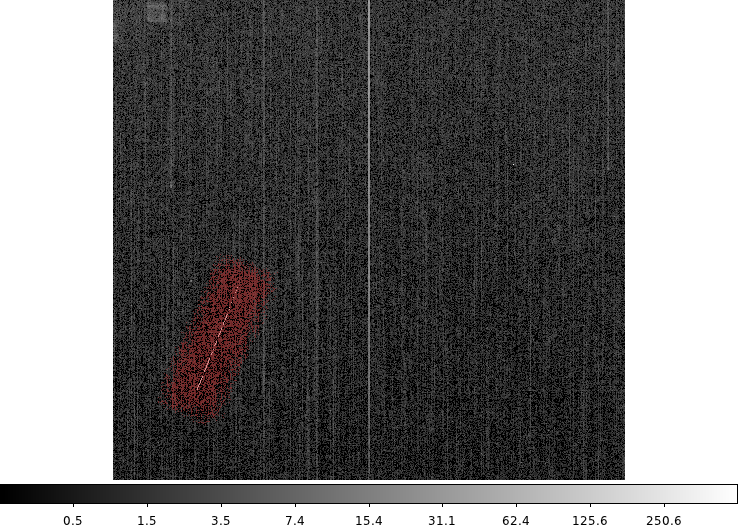

In [11]:
ds9 chip${ccd_id}_evt1.img -scale log -block 2 -scale limits 0 500 \
  -mask transparency 50 -mask color firebrick -mask chip${ccd_id}_bad_evt1.img  \
  -saveimage png ds9_02_evt1_chipimg.png -quit

display < ds9_02_evt1_chipimg.png

Okay, so that's interesting.  We've seen bad columns but this goes diagonally across the chip.

Since we are looking at the evt1 file, we see all the events: all grades, all statuses, so we see the mid-chip node boundary.  

## Why is Level 2 clean?

Going from L1 to L2, there are only 3 filters applied:

1. grade
2. status
3. time (GTI)

I'm only going to check the first two.  The GTI filter won't be an issue here since it would affect all events and given the number of events in the region it's not the actor.

### Check status bits

Using the CIAO contributed script `summarize_status_bits` we can get a summary of the status bits for events in the region.  Be sure to be setup for CIAO rather than the DS release.

In [12]:
summarize_status_bits "${evt1}[sky=${skyreg}]"


BitName    Bit  NumEvt   %Evt  BitDesc
-------    ---  ------   ----  -------
BADPIX       4  927049   99.0  Center of event island falls on bad pixel
BADPIXE      5  579972   62.0  Surrounding event island falls on bad pixel
BADBIAS      6     100    0.0  Bad bias value (4095)
GLOW        16      48    0.0  Event is part of a cosmic ray afterglow


Well, 99% of the events are marked as `BADPIX` (bad pixels) so that's definitely something to look at.

### Check grades

In [13]:
dmextract "${evt1}[sky=${skyreg}][bin grade=0:7:1]" - opt=generic | \
  dmlist "-[cols grade,counts]" data,clean

#  GRADE                COUNTS
                    0     357750
                  1.0       1422
                  2.0     554770
                  3.0        413
                  4.0        409
                  5.0       2548
                  6.0       1535
                  7.0      17118


Nope.  Most of the events are `GRADE=0` or `GRADE=2` both good grades.

This is actually suspicious since this is a front-side CCD and most of the events, like 80%, are typically bad grades.   But not relevant here. The standard grade filter will not have removed these events.

So, the only thing we need to look at is the badpixel file.


## Bad pixel file

The badpixel file contains 1 FITS HDU for each active CCD.

In [14]:
bpix1=21842/primary/acisf21842_000N001_bpix1.fits

In [15]:
dmlist $bpix1 blocks

 
--------------------------------------------------------------------------------
Dataset: 21842/primary/acisf21842_000N001_bpix1.fits
--------------------------------------------------------------------------------
 
     Block Name                          Type         Dimensions
--------------------------------------------------------------------------------
Block    1: PRIMARY                        Null        
Block    2: BADPIX0                        Table         6 cols x 1317     rows
Block    3: BADPIX1                        Table         6 cols x 1508     rows
Block    4: BADPIX2                        Table         6 cols x 1658     rows
Block    5: BADPIX3                        Table         6 cols x 1379     rows


The format is a FITS region file so I can display is (almost) directly in ds9. 

> Note:
>
> There are column name diffs that prevent ds9 from displaying directly so we use `dmmakereg` to
> basically just rename columns.

In [16]:
dmmakereg region="region(${bpix1}[badpix${ccd_id}])" out=bad${ccd_id}.reg ker=fits clob+

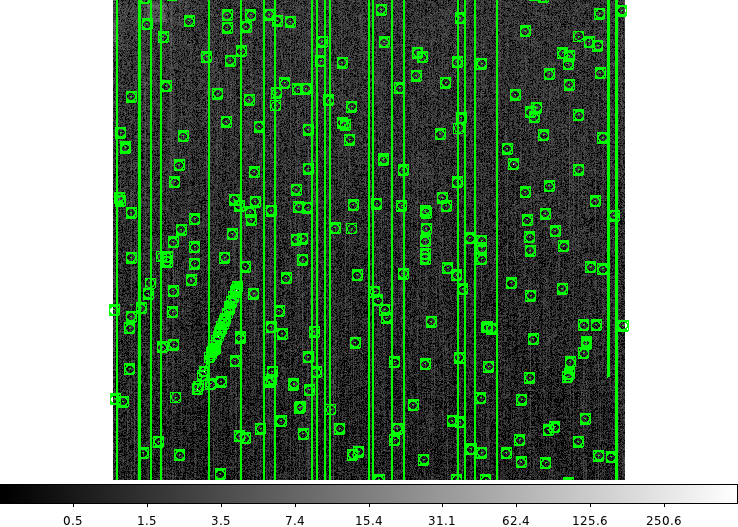

In [17]:
ds9 chip${ccd_id}_evt1.img -scale log -block 2 -scale limits 0 500 \
  -region bad${ccd_id}.reg \
  -saveimage png ds9_02aa_evt1_chipimg_bpix.png -quit

display < ds9_02aa_evt1_chipimg_bpix.png

This shows us the location of all the bad pixels, and yes there are a lot of them.

We can see the linear anomaly.  But this only gives us the location, it doesn't tell us _why_ the 
pixels are being identified as bad.

### Identify why pixels are bad

The bpix file has a `STATUS` column which is a bit-encoded value indicating why pixels are bad.

I have a little utility tool that converts the bpix1 table into an image where the pixel value is the status value.


In [18]:
/bin/rm -rf Bpix2Img
git clone https://github.com/kglotfelty/Bpix2Img 

Cloning into 'Bpix2Img'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12 (delta 2), reused 8 (delta 1), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [19]:
./Bpix2Img/bpix2img "${bpix1}[badpix${ccd_id}]" bpix_status_${ccd_id}.img

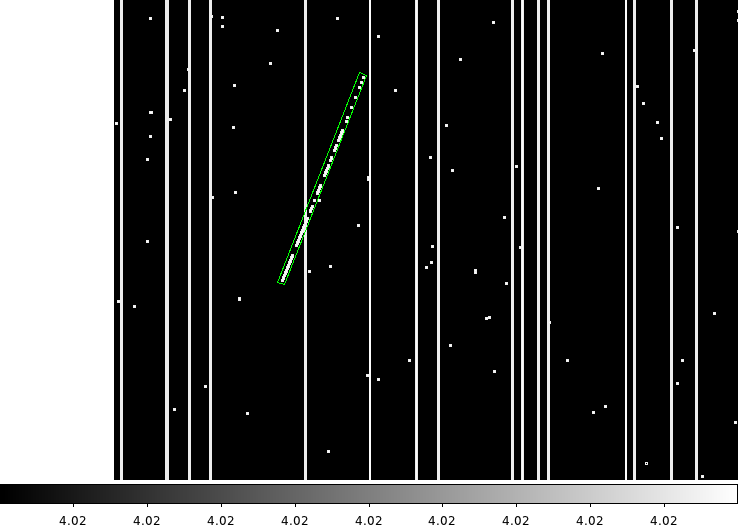

In [20]:
ds9 bpix_status_${ccd_id}.img \
  -pan to 256 256 physical -scale histequ \
  -region command "physical;box(208.98745,317.25852,6.9542544,224.96698,338.65005)" \
  -saveimage png ds9_02aa_bpix_chip_statusbits.png -quit

display < ds9_02aa_bpix_chip_statusbits.png

We can filter the image to look at the pixel values

In [21]:
dmlist bpix_status_${ccd_id}.img"[(x,y)=box(208.98745,317.25852,6.9542544,224.96698,338.65005)]" data,clean,array | \
  egrep -v ' 0$' | sort -n | uniq -c

      1 #  PRIMARY[89,213]
    402         256
     17         258
     20       65536
     64       65792
      2       65794


Consulting the badpixel code


```C
acis_build_badpix/acis_build_badpix.h
    92  /* Define bits ; */
    93  extern unsigned long BITS[32]; /* ushort->ulong; 16->32 */
    94  
    95  #define CALIB_BAD_PIX      0    /* in calib db as bad pixel             */
    96  #define CALIB_BAD_COL      1    /* in calib db as bad column            */
    97  #define BIAS_PARITY_BERR   2    /* in bias error file as parity error   */
    98  #define BIAS_BADPIX_BIAS   3    /* in bias image as bad pixel           */
    99  #define BIAS_PARITY_BIAS   4    /* in bias image as parity error        */
   100  #define CHIP_EDGE_COL      5    /* region around the edge of the CCD    */
   101  #define CHIP_EDGE_ROW      6    /* bot & top rows of CCD                */
   102  #define USER_DEFINED       7    /* user defined badpixel                */
   103  #define B3X3_ISLAND        8    /* badpixels in 3x3 neighborhood        */
   104  #define VF_CHIP_EDGE       9    /* pixels along the outer edge in VF mode*/
   105  #define B5x5_ISLAND       10    /* badpixels in 5x5 neighborhood        */
   106  #define MID_CHIP          11    /* event @ Y = 512 | 513                */
   107  #define QUARTER_CHIP      12    /* events @ Y=256|257|768|769           */
   108  #define FEP0_ERROR        13    /* fep 0 error detect                   */
   109  #define HOTPIXEL          14    /* hot pixel in event file              */
   110  #define GLOWING           15    /* afterglow event                      */
   111  #define BIAS_THRESH_FAIL  16    /* if fail on biasthresh, set 16 intead of 3*/
   112  #define USER_INCLUDE_BIT  28    /* bit set for inclusion based on usrfile*/
   113  #define USER_DISABLE_BIT  29    /* bit that needs flipping based on usrfile */
   114  #define BITFLAG3X3        30    /* bitflag produced pixel with 3x3 island*/
   115  #define USER_DELETE                 31    /* user defined bad pixel to delete */
```

Most of the bad pixels are $256=2^8$, `B3X3_ISLAND`, which are the pixels within 1-pixel of another bad pixel.

The interesting ones are the pixels with `BIAS_THRESH_FAIL`, $65536=2^{16}$.   These pixels indicate that the 
`acis_build_badpix` algorithm to detect exceptional high or in this case low bias values.

This is controlled by the `biasthresh` parameter


In [22]:
env PAGER=cat ahelp -n 100 -b PARAM -t biasthresh acis_build_badpix

SUBJECT(acis_build_badpix)                                                            CONTEXT(tools)


PARAM biasthresh

     type=integer
     def=6
     min=3
     max=4000
     reqd=no

     The threshold used to determine whether a bias value is suspiciously high or low 
     (see procbias). If the absolute value of the difference between the bias value for a 
     pixel and the median bias value for that column differ by more than the biasthresh, 
     then the bias value is suspicious and the pixel is written to the output file. 
     Pixels identified as bad in the calibration, bias-parity error, and bias map files 
     are excluded from the computation of the median. The default value of this parameter 
     was chosen with care. Be cautious about using some other value.

So, let's look at the bias images and see if the bias values in that region are more than $\pm$6 ADU above or below the median value.

## Check the bias images


The bias files are in the `secondary` directory

In [23]:
stk_build 21842/secondary/\*bias0.fits out=stdout

21842/secondary/acisf653266286N001_1_bias0.fits
21842/secondary/acisf653266286N001_2_bias0.fits
21842/secondary/acisf653266286N001_3_bias0.fits
21842/secondary/acisf653266286N001_4_bias0.fits


Humm, the files are named \_1\_ through \_4\_, but this is all 4 ACIS-I chips, ie, chips 0 to 3.  What's up?

The bias file names are based on the `FEP_ID` (Front End Processor).  So we need to find which `FEP_ID` goes with `CCD_ID=1`.  This information is in several places, the easiest is to look in the parameter block, `pbk0` file.


In [24]:
dmlist 21842/secondary/*pbk0.fits"[ccd_id=${ccd_id}][cols ccd_id,fep_id]" data,clean

#  CCD_ID FEP_ID
    1    3


Ok, so `FEP_ID=3`

In [25]:
fep_id=3

### Take a look at the original bias

I'll include the same mask I used before to help us see the anomaly region.

In [26]:
bias0=21842/secondary/acisf653266286N001_${fep_id}_bias0.fits 

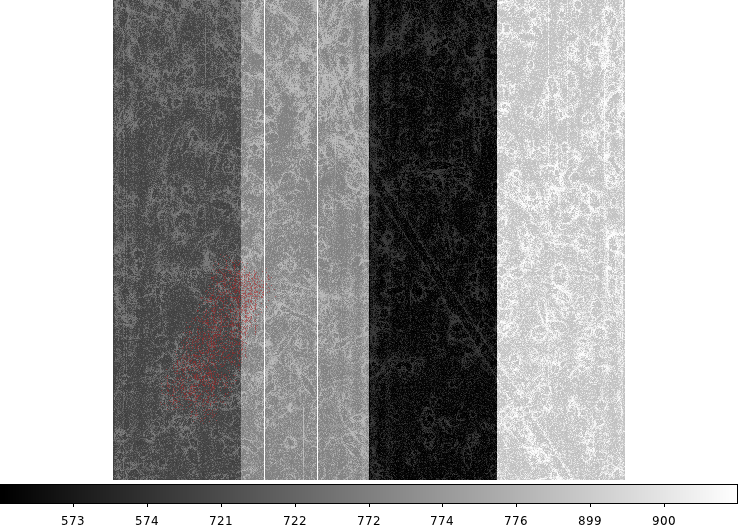

In [27]:
ds9 ${bias0} -scale histequ -zoom to 0.5 \
  -mask color firebrick -mask transparency 50 -mask chip${ccd_id}_bad_evt1.img  \
  -saveimage png ds9_03a_bias0.png -quit

display < ds9_03a_bias0.png

Well, the node-to-node bias offset is obvious, but the mask is hard to see.  This is because it is based on the 
detected events so there are gaps between the pixels in the mask.

### Making a better mask


We can apply a morphological _closing_ to the mask to fill in the gaps to make the mask look better.  To do this we 
_diolate_ the mask to fill in the gaps, and then _erode_ the mask to remove the excess around the edge. The value `numiter=10` was chosen arbitrarily to make sure space between events was filled in.

These operations can be apply to greyscaled images (ie not binary) using the `min` and `max` filter functions.

In [28]:
dmimgfilt chip${ccd_id}_bad_evt1.img  - max "box(0,0,3,3)" numiter=10 | \
  tee chip${ccd_id}_diolate.img | \
  dmimgfilt -  chip${ccd_id}_bad_evt1.mask min "box(0,0,3,3)" numiter=10 clob+

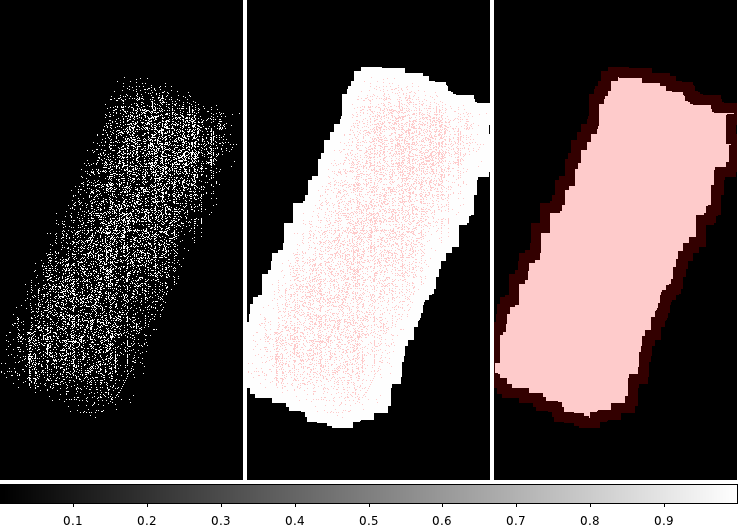

In [29]:
ds9 -scale limits 0 1 -tile column \
  chip${ccd_id}_bad_evt1.img \
  chip${ccd_id}_diolate.img \
  chip${ccd_id}_bad_evt1.mask \
  -tile column \
  -frame 1 \
  -pan to 212 322 physical \
  -frame 2 \
  -mask color red -mask transparency 80 -mask chip${ccd_id}_bad_evt1.img \
  -pan to 212 322 physical \
  -frame 3 \
  -mask color red -mask transparency 80 -mask chip${ccd_id}_diolate.img \
  -pan to 212 322 physical \
  -saveimage png diolate_erode.png -quit

display < diolate_erode.png


Left is the original mask.  Center is the mask after it has been diolated to fill in the gaps between the events.  Right is then after the erosion to remove the excess at the edge.

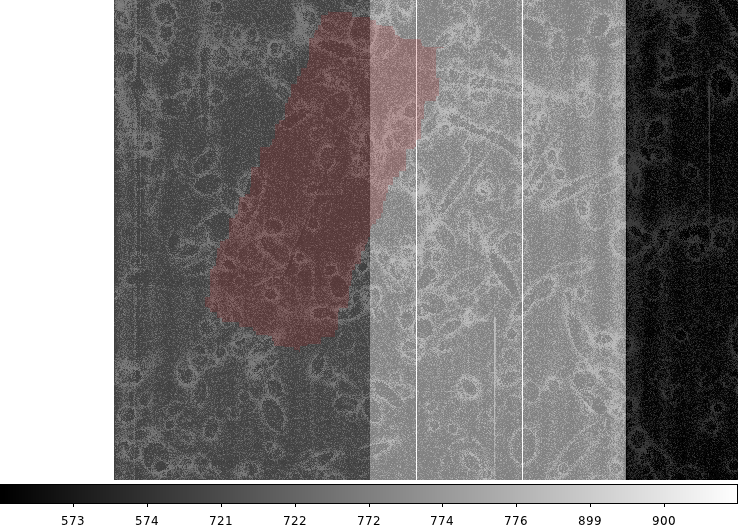

In [30]:
ds9 $bias0 -scale histequ -zoom to 1 \
  -mask color firebrick -mask transparency 80 -mask chip${ccd_id}_bad_evt1.mask  \
  -pan to 256 256 physical \
  -saveimage png ds9_03b_bias0.png -quit

display < ds9_03b_bias0.png

> Note
>
> I zoomed in on the affected region.

Okay ... so now what? 

We can see the diagonal linear feature in the middle of the shaded region but hard to judge what's going on.

### Flatten the bias (subtract per-column variation) 

Let's subtract the per-column median and see what it looks like.

Here I use `dmimgproject` to project the data onto the X-axis.  The term "project" is used very loosely by the tool.
It compute various statistics based on the values in the column such as `mean` and `sum` which are typical projection operations.  However, it also computes things like the `median` which is the value of interest here.

After we obtain the median value per column, we then replication that value back along each column using the `dmimgreproject` tool.

Finally, then we subtract the column-wise median from the original bias to obtain the flat bias.

In [31]:
dmimgproject $bias0 - x | \
  dmimgreproject "-[cols x,median]" $bias0 - | \
  dmimgcalc $bias0 - flat_bias0.img sub clob+

BTIMDRFT values are different...FAIL...
BTIMNULL values are different...FAIL...
BTIMRATE values are different...FAIL...


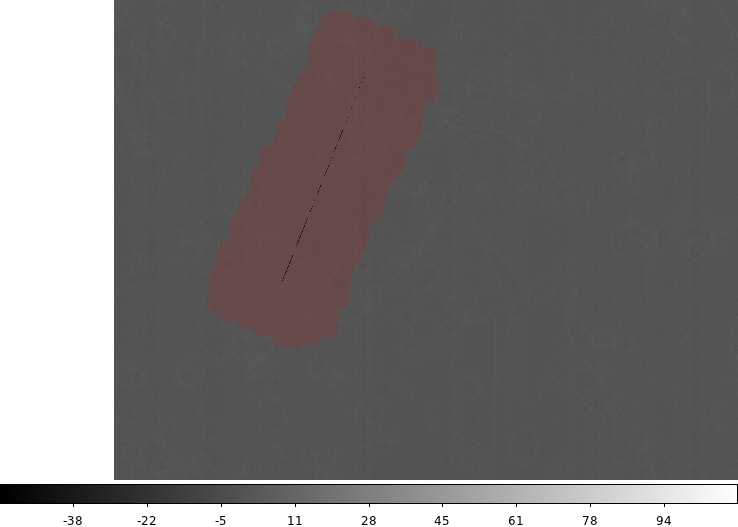

In [32]:
ds9 flat_bias0.img -scale linear -zoom to 1 \
  -mask color firebrick -mask transparency 80 -mask chip${ccd_id}_bad_evt1.mask  \
  -pan to 256 256 physical \
  -saveimage png ds9_04_flat_bias0.png -quit

display < ds9_04_flat_bias0.png

> Important: 
>
> These DM tools are only approximating the algorithm used by `acis_build_badpix`.  The exact values
> determined by the tool can probably only be determined by jumping into the debugger or maybe turning up
> the verbosity.


Now we can see the anomaly more clearly.  Based on the ds9 colorbar we can see the pixel values are 
extraordinarily low compared to the surrounding pixels.


### Magnitude of bias anomaly 

We saw above that the `biasthresh` is set to `6`.  So we just want to be sure that the pixel values in the anomaly are indeed less than `-6`.

What I want to do now is create a region around the anomaly. 

There are several ways to do this.  I tried a few others but found the technique shown below the easiest to create 
and visualize.


So based on looking at the previous image, the bias values are low.  I want to make a region that includes the 3x3 pixel island.    I can do this using the same _diolate_ technique above to expand those low values into the neighboring pixels.

I can then use `dmimgthresh` to apply two thresholds.

- Anything greater than -7 is set to 0. 
- Anything less than 0 is then set to 1.

This will create a mask where the anomaly and it's 3x3 neighborhood will be 1 and all other pixels will be 0.



In [33]:
dmimgfilt flat_bias0.img - min "box(0,0,3,3)" | \
  dmimgthresh - - cut=:-7 value=0 | \
  dmimgthresh - evt.mask cut=0 value=1 clob+

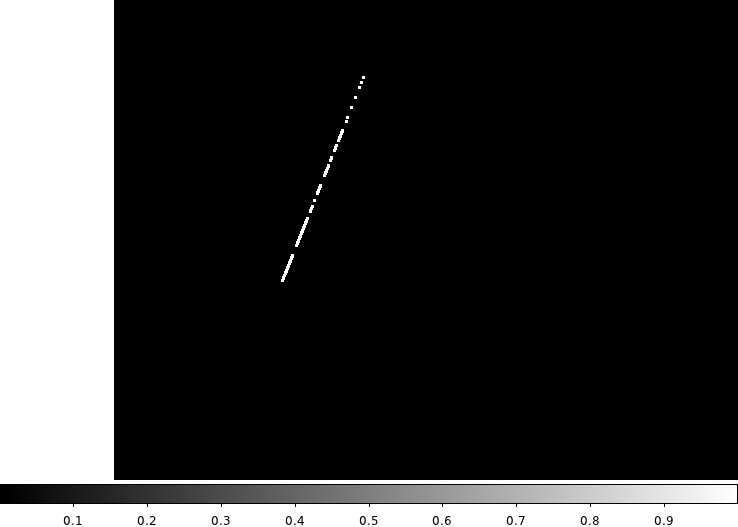

In [34]:
ds9 evt.mask -scale linear -zoom to 1 \
  -pan to 256 256 physical \
  -saveimage png ds9_06_evt_mask.png -quit

display < ds9_06_evt_mask.png 

Great.  We now have a mask showing where the anomaly is.

### pixel masks?

Hey -- can I use this with the nifty new dm pixel mask filtering?

In [35]:
dmlist ${evt1}"[ccd_id=${ccd_id},(chipx,chipy)=mask(evt.mask)]" counts || echo


Failed to open virtual file 21842/secondary/acisf21842_000N001_evt1.fits[ccd_id=1,(chipx,chipy)=mask(evt.mask)]
# DMLIST (CIAO 4.10): Mask validation failure, mismatch descriptor component name of mask and source: "chip(X,Y)" vs "chip(chipx,chipy)".



Opps.  Oh well.  I have to turn it into a standard region file.

### Create region

There are a couple of different ways to do this; since the anomaly doesn't hit the edges, I can use
`dmcontour` to make a region around the pixels.

I use a level of `0.5` since the pixels in the mask are 1 and not in the mask are 0; this gives me a contour that 
follows as close as possible to the edge of the pixel boundaries. (ie is half way between the centers of the pixels.)

In [36]:
dmcontour evt.mask 0.5 evt_mask.reg clob+

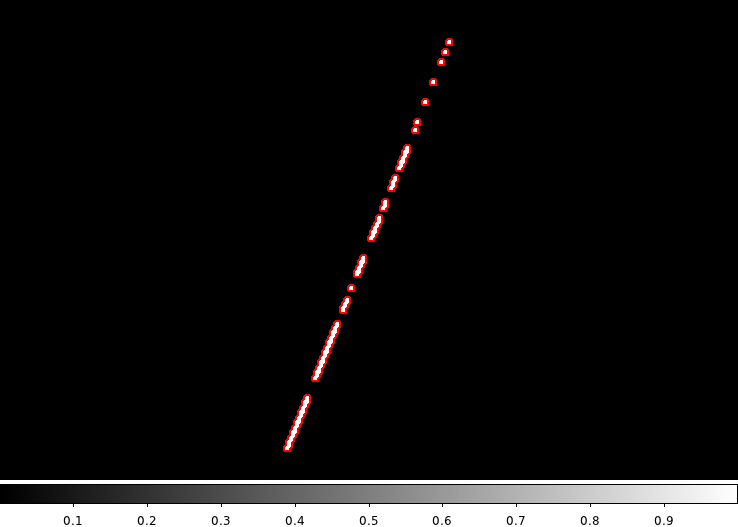

In [37]:
ds9 evt.mask -scale linear -zoom to 2 \
    -region color red -region width 2 \
    -region evt_mask.reg \
    -pan to 210 320 physical \
  -saveimage png ds9_07_evt_mask.png -quit

display < ds9_07_evt_mask.png 

### Check region filter

Let's check the filter using the `summarize_status_bits` tool 

In [38]:
summarize_status_bits "${evt1}[ccd_id=${ccd_id}][(chipx,chipy)=region(evt_mask.reg)]"


BitName    Bit  NumEvt   %Evt  BitDesc
-------    ---  ------   ----  -------
BADPIX       4  926817  100.0  Center of event island falls on bad pixel
BADPIXE      5  579660   62.5  Surrounding event island falls on bad pixel


That looks like it's got it.  All the events have `BADPIX` status.

So, we can verify that the bias is "bad" and so we'll "repair" it.

## Bias repair

I don't have access to the DSOPS network so I'll go ahead and create my own repaired bias.

**The technique shown here is NOT AT ALL like what DSOPS does**

This is a quick way to replace the bias values with typical nearby values.  Ultimately the difference won't matter.  We'll see why later.





### Create a _donor_ bias

The bias repair technique starts by obtaining a bias from a different observation.  Rather than do that, I'm just going to create one from the existing bias image.

To do this, I'll use a "median box ring" nonlinear filter.  Each pixel in the image is replaced with the median of the
pixel values in a box surrounding it.  I'll use a `box` and exclude the `point` in the middle.


In [39]:
dmimgfilt ${bias0} fixed.bias median "box(0,0,5,5)-point(0,0)" clob+

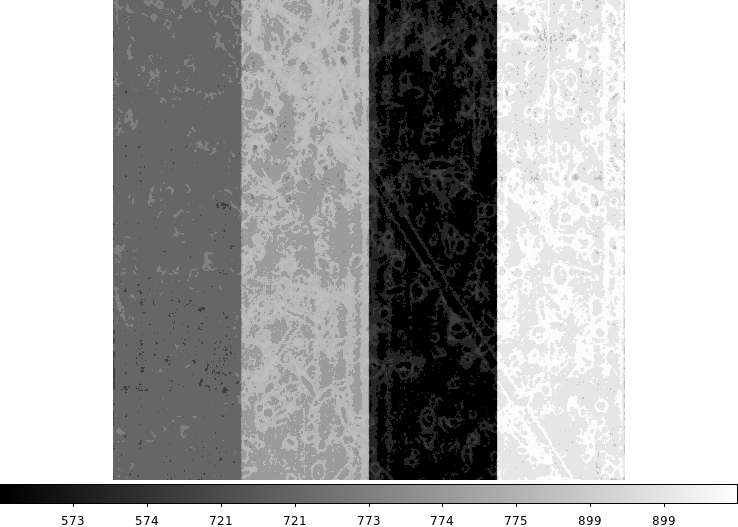

In [40]:
ds9 fixed.bias -scale histequ \
  -zoom to 0.5 \
  -saveimage png ds9_09a_median_ring.png -quit

display < ds9_09a_median_ring.png 

This looks good.  

> Note: 
> 
> This technique will probably not work across nodes due to the DC offset (the median is not as meaningful)



### Extract patch from donor and apply

We'll now extract out the region from the donor bias and replace the pixel values in the original image.

There are various ways we could do this. Maybe the most basic (and robust) would be something like

- filter the original bias and exclude the anomaly region
- filter the donor bias and include the anomaly region
- add the two image together.

I'm using a different approach here.  I'm going to use a stack of files as input to the `dmimgfilt` tool.  I'm then going to pick the maximum pixel value of those two.  The key is that the donor is filtered with the anomaly region so only those pixels are non-zero.  It's a very specialized use but this is a very special case.



In [41]:
dmimgfilt "${bias0},fixed.bias[(#1,#2)=region(evt_mask.reg)][opt full]" repair.bias max "point(0,0)" clob+

BTIMDRFT values are different...FAIL...
BTIMNULL values are different...FAIL...
BTIMRATE values are different...FAIL...


### Check repair

The best way to check the repair is to subtract it from the original to make sure only the 
anomaly region has changed


In [42]:
dmimgcalc $bias0 repair.bias repair_diff sub clob+

BTIMDRFT not present in all input files...FAIL...
BTIMNULL not present in all input files...FAIL...
BTIMRATE not present in all input files...FAIL...


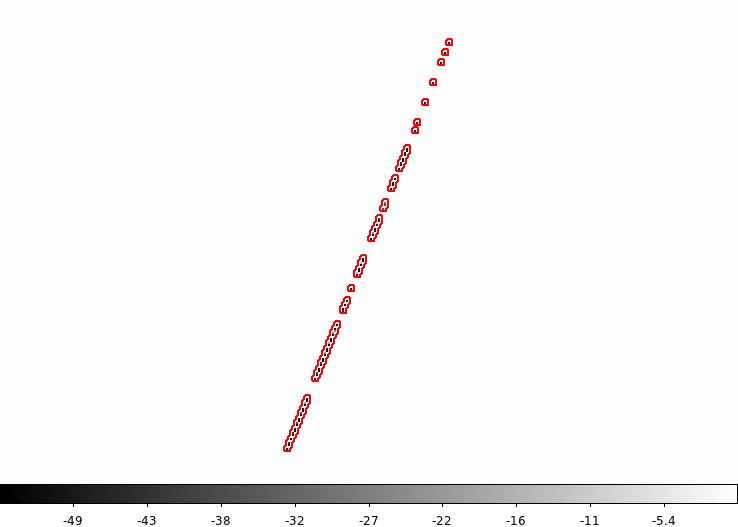

In [43]:
ds9 repair_diff -scale linear -zoom to 2 \
  -region color red -region width 2\
  -region evt_mask.reg \
  -pan to 210 320 physical \
  -saveimage png ds9_09_repair_diff.png -quit
  

display < ds9_09_repair_diff.png  

Very good.  

## Re-run pipeline

Now we have to re-run the acis_pipeline 

### Setup pipeline directories

In [44]:
/bin/rm -rf pipeline_repair_run
mkdir -p pipeline_repair_run
mkdir -p pipeline_repair_run/input
mkdir -p pipeline_repair_run/output
mkdir -p pipeline_repair_run/param

### Symlink inputs and create lists

In [45]:
indir=`pwd`/pipeline_repair_run/input
outdir=`pwd`/pipeline_repair_run/output
root=_fake_bias_repair
obiroot=f21842_000N001
biasroot=acis_fake_bias_repair

In [46]:
#bias0 -- replace bias with repaired version
b=`basename $bias0`
/bin/ls `pwd`/21842/secondary/acisf653266286N001_?_bias0.fits | (cd $indir ; xargs -I@ ln -s @ ./ )
/bin/ls `pwd`/repair.bias | ( cd $indir; xargs -I@ ln -s @ ./)
(cd $indir; /bin/ls acisf653266286N001_?_bias0.fits | sed "s,${b},repair.bias," > ${biasroot}_bias0.lis)

In [47]:
#asol
/bin/ls `pwd`/21842/primary/pcadf*asol1.fits | (cd $indir ; xargs -I@ ln -s @ ./ )
(cd $indir; /bin/ls pcadf*asol1.fits > pcad${root}_asol1.lis)

In [48]:
#pbk
/bin/ls `pwd`/21842/secondary/acisf*_pbk0.fits | (cd $indir ; xargs -I@ ln -s @ ./ )
(cd $indir; /bin/ls acisf*_pbk0.fits > acis${root}_pbk0.lis)

Note: the `evt0` and `exr0` files are not available via `chaser` (despite being listed in the 
custom download section).  They can only be obtained using `arc4gl`.

In [49]:
#evt0
/bin/ls `pwd`/21842/supporting/acisf653267345N002_?_evt0.fits | (cd $indir ; xargs -I@ ln -s @ ./ )
(cd $indir; /bin/ls acisf653267345N002_?_evt0.fits > acis${root}_evt0.lis)

In [50]:
#exr0
/bin/ls `pwd`/21842/supporting/acisf653267345N002_?_exr0.fits | (cd $indir ; xargs -I@ ln -s @ ./ )
(cd $indir; /bin/ls acisf653267345N002_?_exr0.fits > acis${root}_exr0.lis)

Note: we need _the_ `obs0a.par`, not the surrogate created using `dmmakepar` on the event file header.  There's info in the
actual `obs0a.par` that is not stored in the headers.

In [51]:
#obs0a.par
ln -s `pwd`/21842/supporting/axaff21842_000N001_obs0a.par $indir/

In [52]:
#win0 : there isn't one, make an empty list file.
(cd $indir; touch acis${root}_win0.lis)

In [53]:
#berr0
/bin/ls `pwd`/21842/supporting/acisf*_berr0.fits | (cd $indir ; xargs -I@ ln -s @ ./ )
(cd $indir; /bin/ls acisf*_berr0.fits > acis${root}_berr0.lis)

In [54]:
#hkp0
/bin/ls `pwd`/21842/supporting/acisf*_hkp0.fits | (cd $indir ; xargs -I@ ln -s @ ./ )
(cd $indir; /bin/ls acisf*_hkp0.fits > acis${root}_hkp0.lis)

> I'm going to skip the MTL stuff and just run the pipeline through a_p_e

In [55]:
/bin/ls -l $indir/*.lis | sed s,`pwd`/,,

-rw------- 1 kjg sds  32 Oct 24 07:32 pipeline_repair_run/input/acis_fake_bias_repair_berr0.lis
-rw------- 1 kjg sds 108 Oct 24 07:32 pipeline_repair_run/input/acis_fake_bias_repair_bias0.lis
-rw------- 1 kjg sds 124 Oct 24 07:32 pipeline_repair_run/input/acis_fake_bias_repair_evt0.lis
-rw------- 1 kjg sds 124 Oct 24 07:32 pipeline_repair_run/input/acis_fake_bias_repair_exr0.lis
-rw------- 1 kjg sds  58 Oct 24 07:32 pipeline_repair_run/input/acis_fake_bias_repair_hkp0.lis
-rw------- 1 kjg sds  29 Oct 24 07:32 pipeline_repair_run/input/acis_fake_bias_repair_pbk0.lis
-rw------- 1 kjg sds   0 Oct 24 07:32 pipeline_repair_run/input/acis_fake_bias_repair_win0.lis
-rw------- 1 kjg sds  30 Oct 24 07:32 pipeline_repair_run/input/pcad_fake_bias_repair_asol1.lis


### Create pipeline `.ped` file

In [56]:
tcsh -c "source ~/.ascrc -r release;pbuilder.pl  -t \$ASCDS_INSTALL/profile/acis_lev1.ped -i $indir -o $outdir -r $root -a biasroot=$biasroot -a obiroot=$obiroot -a revision=999 > $outdir/pipe.ped" 


**************************************
*** Welcome to the CXC Data System ***
**************************************
CIAO configuration is complete... 
10.6.4.1  Tuesday, September 11, 2018
  bindir      : /home/ascds/DS.release/bin
  CALDB       : 4.8.0
setting production environment for Mission Planning...
setting production environment for Proposal applications....
CXC Data System, version: 10.6.4.1  Tuesday, September 11, 2018


### Run pipeline

I'm not worried about the back-end of the pipeline: the mission time line stuff and the meta-data updates.

In [57]:
tcsh -c "source ~/.ascrc -r release;cd $outdir;flt_pctr -prof pipe.ped -stopat skyfov -showlog" || echo 

**************************************
*** Welcome to the CXC Data System ***
**************************************
CIAO configuration is complete... 
10.6.4.1  Tuesday, September 11, 2018
  bindir      : /home/ascds/DS.release/bin
  CALDB       : 4.8.0
setting production environment for Mission Planning...
setting production environment for Proposal applications....
CXC Data System, version: 10.6.4.1  Tuesday, September 11, 2018
2018_297_11:33:02	Successfully started acis_lev1_calib
2018_297_11:33:03	acis_lev1_calib completed successfully.
2018_297_11:33:03	Successfully started set_obsfile
2018_297_11:33:04	set_obsfile completed successfully.
2018_297_11:33:04	Successfully started set_acis_events
2018_297_11:33:05	set_acis_events completed successfully.
2018_297_11:33:05	Successfully started deltoclk
2018_297_11:33:06	deltoclk completed successfully.
2018_297_11:33:06	Successfully started acis_format_events
2018_297_11:33:14	acis_format_events completed successfully.
2018_297_11:33:1

In [58]:
 grep '^Name:.*acis_process_events$' pipeline_repair_run/output/pipe.ped.log --after-context 14 --before-context 1 | \
 sed "s,`pwd`/,,"

--------------------------------------------------------------------------------
Name:			acis_process_events
--------------------------------------------------------------------------------


Execution:

Output was redirected to STDOUT by the -showlog or -showoutput flag.

# acis_process_events (10.6.4.1): WARNING: The ra_targ, dec_targ, or roll_nom specified by pipeline_repair_run/output/axaff21842_000N001_obs0a.par does not match the values in the event file- using the obs.par values.
# acis_process_events (10.6.4.1): The following error occurred 1838021 times:
	dsAPEPHAZEROERR -- WARNING: an event's summed pha is zero or null.


End Execution



### Check pipeline results

Let me check the header of the event file to be sure that it picked up the repaired bias

In [59]:
repair_evt=pipeline_repair_run/output/acis_fake_bias_repair_evt1.fits
dmlist ${repair_evt} header,clean | grep BIAS

BIASFIL3             acisf653266286N001_1_bias0.fits bias file used: CCD 3
BIASFIL2             acisf653266286N001_2_bias0.fits bias file used: CCD 2
BIASFIL1             repair.bias                    
BIASFIL0             acisf653266286N001_4_bias0.fits bias file used: CCD 0


Huzzah!

## Examine repaired results

### check status bits

In [60]:
summarize_status_bits "${repair_evt}[ccd_id=${ccd_id}][(chipx,chipy)=region(evt_mask.reg)]"


BitName    Bit  NumEvt   %Evt  BitDesc
-------    ---  ------   ----  -------
BADLM        1  925819   99.9  Center pixel PHA not local maximum
BADPIX       4   17879    1.9  Center of event island falls on bad pixel
BADPIXE      5   53621    5.8  Surrounding event island falls on bad pixel
GLOW        16  142844   15.4  Event is part of a cosmic ray afterglow


Well, that is very different from before.

We've gone from 100% of events identified as `BADPIX` to only 1.9%.  But now 99.9% of the events are identified as `BADLM`.

This is actually expected.  

In the original processing the bias was low.  We have increased the bias values.

The bad events on the anomaly have the center pixel on the anomaly -- the definition of an event is that the center pixel must be the local max in the 3x3 event island.

Since we've increased the bias, the bias corrected `PHA` value for the center pixel is now reduced. 

As we see, it's been reduced so much that for 99.9% of the events, the center pixel is no longer the local max in the 3x3 island.  This is the origin of the status bit.

### Create L2 file 

In [61]:
dmcopy "${repair_evt}[status=0,grade=0,2,3,4,6]" repair_evt2.fits clob+

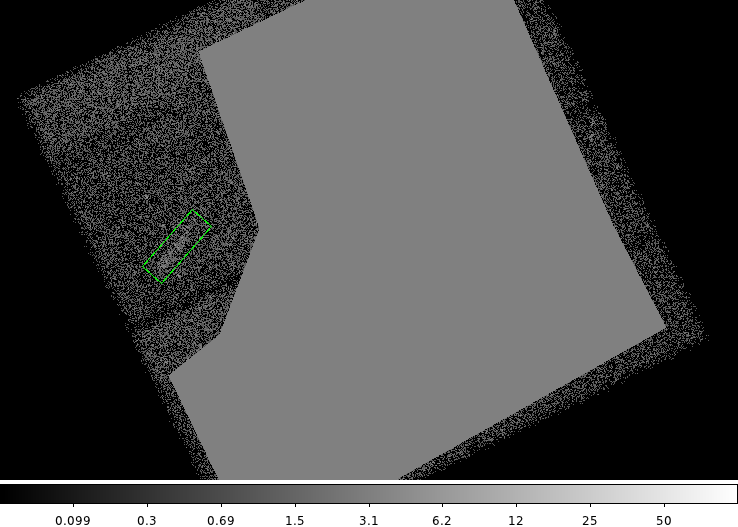

In [62]:
ds9 repair_evt2.fits -bin to 4 -scale log -scale limits 0 100 \
  -regions command "physical;${skyreg}" \
  -regions command "${hiddenreg}" \
  -saveimage ds9_10_repair_evt_sky.png -quit

display < ds9_10_repair_evt_sky.png 

which as we expect ... there are still bad residual events inside the repair region.

### Check chip coordinates

This time we are looking at the level 2 event file in chip coords

In [63]:
dmcopy repair_evt2.fits"[ccd_id=${ccd_id}][bin chip=1]" repair_chip${ccd_id}_evt2.img clob+

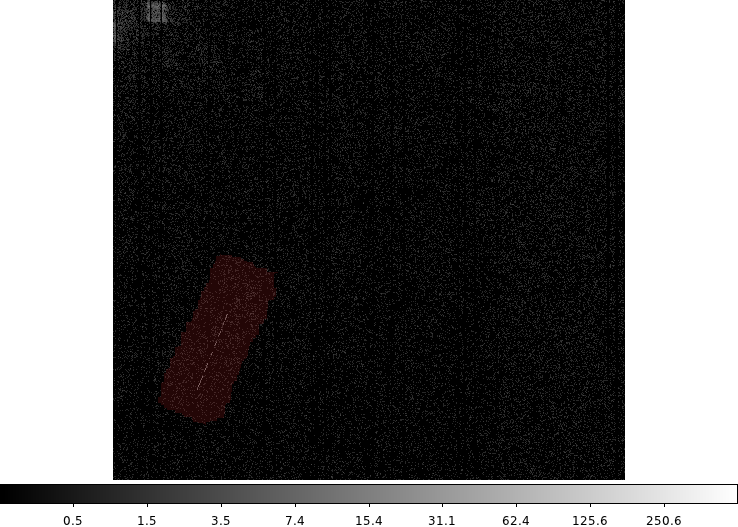

In [64]:
ds9 repair_chip${ccd_id}_evt2.img -scale log -block 2 -scale limits 0 500 \
  -mask transparency 80 -mask color firebrick -mask chip${ccd_id}_bad_evt1.mask \
  -saveimage png ds9_11_repair_evt2_chipimg.png -quit

display < ds9_11_repair_evt2_chipimg.png

So we can indeed still see some events in the anomaly 

> Note:
>
> Since we're looking at the evt2 file, the other bad columns are easier to see as is the
> source at the top of the chip showing up in the dither pattern.

### Let's check new badpixel file

We'll check the new bad pixel file, and overlay it on the flattened, repaired bias image

In [65]:
dmimgproject repair.bias - x | \
  dmimgreproject "-[cols x,median]" repair.bias - | \
  dmimgcalc repair.bias - flat_repair.bias sub clob+
  

dmmakereg region="region(pipeline_repair_run/output/acis_fake_bias_repair_bpix1.fits[badpix${ccd_id}])" \
  out=repair_bpix.reg ker=fits clob+
  
  

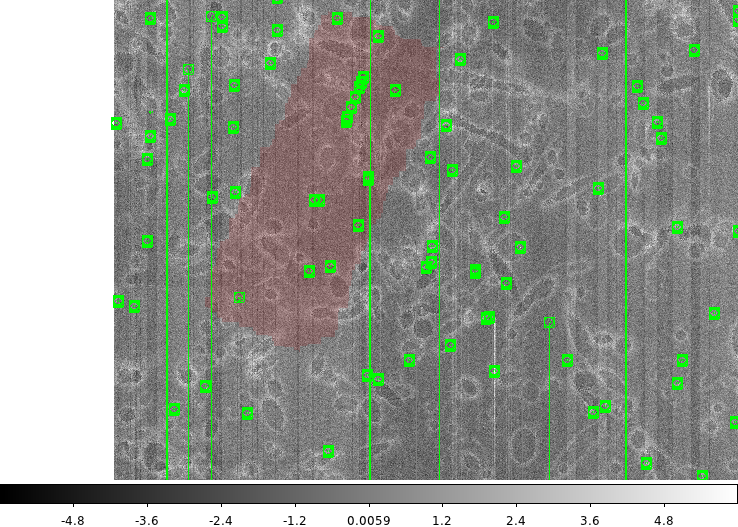

In [66]:
ds9 flat_repair.bias -region repair_bpix.reg -scale limits -6 6 -scale linear \
 -mask color firebrick -mask transparency 80 -mask chip${ccd_id}_bad_evt1.mask  \
  -pan to 256 256 physical \
  -saveimage png ds9_12_flat_repair_bias.png -quit

display < ds9_12_flat_repair_bias.png

Okay, most of the pixels in the anomaly are **no longer** being identified as bad.  The few that are 
are showing up as afterglows, not bias threshold violations. 

This is exactly what we asked for though.  We "repaired" the bias so the values wouldn't be low; they aren't, therefore the badpixel file no longer includes them.

### Residual bad event statistics

Let's now look at those residual bad events in the anomaly region.

In [67]:
still_bad=repair_evt2.fits"[ccd_id=1,(chipx,chipy)=region(evt_mask.reg)]"

### How many events?

In [68]:
dmlist "${still_bad}" counts

405     


### What about `PHA` values?

In [69]:
dmextract "${still_bad}[bin pha=0:400:1]" - op=generic | \
  dmlist -"[cols pha,counts]" data,clean | egrep -v ' 0$' | head -20


# dmextract (CIAO 4.10): WARNING: extracting generic histogram for pha column.  You might instead want to use opt=pha1 or opt=ltc1.
# dmextract (CIAO 4.10): WARNING: Keywords LIVETIME and EXPOSURE not found in file 'repair_evt2.fits'
		LIVETIME set to default 1.0

#  PHA                  COUNTS
                 17.0          5
                 18.0         31
                 19.0         56
                 20.0         67
                 21.0         39
                 22.0         28
                 23.0         31
                 24.0         18
                 25.0         11
                 26.0          3
                 27.0          1
                 28.0          1
                 29.0          1
                 30.0          2
                 32.0          2
                 33.0          2
                 34.0          3
                 35.0          4
                 36.0          9


Well, we see that most of the `PHA` values are low -- actually they are very low.  Hummm ...

### What about `PHA_RO` values?
`PHA` is corrected for things like CTI.  What about the raw `PHA_RO` (ro = read out).

In [70]:
dmextract "${still_bad}[bin pha_ro=0:400:1]" - op=generic | \
  dmlist -"[cols pha_ro,counts]" data,clean | egrep -v ' 0$' | head -20

# dmextract (CIAO 4.10): WARNING: Keywords LIVETIME and EXPOSURE not found in file 'repair_evt2.fits'
		LIVETIME set to default 1.0

#  PHA_RO               COUNTS
                 13.0        112
                 14.0         79
                 15.0         43
                 16.0         32
                 17.0         12
                 18.0          6
                 19.0          2
                 20.0          2
                 21.0          1
                 26.0          7
                 27.0          7
                 28.0          8
                 29.0         14
                 30.0          7
                 31.0          6
                 32.0          6
                 33.0          3
                 34.0          3
                 35.0          5


**That's suspicious**

The suspicious thing is that the `PHA_RO` values start at **`13`**.  This is the event _split threshold_ value.  The thing is the split threshold is much lower than the _event threshold_.  

We'll come back to this shortly.

### Check `GRADE` values

In [71]:
dmextract "${still_bad}[bin grade=0:7:1]" - op=generic | \
  dmlist -"[cols grade,counts]" data,clean 

# dmextract (CIAO 4.10): WARNING: Keywords LIVETIME and EXPOSURE not found in file 'repair_evt2.fits'
		LIVETIME set to default 1.0

#  GRADE                COUNTS
                    0        306
                  1.0          0
                  2.0         22
                  3.0         30
                  4.0         21
                  5.0          0
                  6.0         26
                  7.0          0


That looks alright.  The larger number of grade=0 events is consistent with the low PHA values.

Just should we be seeing events with PHA values that low?

# Diagnosis

OK -- so what's happening?

## Thresholds:  `EVT` (event) threshold vs. `SPL` (split)

From the POG [Section 6.2](http://cxc.harvard.edu/proposer/POG/html/chap6.html#tth_sEc6.2)

> ... which, after removing bias (see Section 6.14), identifies the position and amplitude of any "events" according to a number of criteria depending on the precise operating mode. These criteria always require a local maximum in the charge distribution above the event threshold (see Table 6.2). 



The _event threshold_ `EVT`, is used on board to filter events.  It is the minimum `PHA` value an event can have, after bias subtraction and overclock correction.  The event theshold is obtained by summing the pixels in the 3x3 island which have individual `PHAS` values >= the _split threhold_, `SPL`.  The split threshold also then comes into play when determining events' `FLT_GRADE` and `GRADE`.

### Ground vs On Orbit Processing

On the ground, the event and split threshold values are stored in the CALDB

In [72]:
# first block is for TE 
dmlist $CALDB/data/chandra/acis/evtsplt/acisD2005-07-01evtspltN0002.fits data

 
--------------------------------------------------------------------------------
Data for Table Block AXAF_EVTSPLT0
--------------------------------------------------------------------------------
 
ROW    CCD_ID     EVT_THR[4]                               SPL_THR[4]
 
     1          0                            [38 38 38 38]                            [13 13 13 13]
     2          1                            [38 38 38 38]                            [13 13 13 13]
     3          2                            [38 38 38 38]                            [13 13 13 13]
     4          3                            [38 38 38 38]                            [13 13 13 13]
     5          4                            [38 38 38 38]                            [13 13 13 13]
     6          5                            [20 20 20 20]                            [13 13 13 13]
     7          6                            [38 38 38 38]                            [13 13 13 13]
     8          7          

### `acis_process_events`

However, `acis_process_events` does not use the **event** threshold.  It only uses the split threshold


```C
acis_process_events/load_threshold_table.c:

    89        if (extension)
    90        {
    91          num_rows = dmTableGetNoRows(extension);
    92  
    93          desc[0] = dmTableOpenColumn(extension, "CCD_ID");
    94          desc[1] = dmTableOpenColumn(extension, "SPL_THR");
    95  
    96          while (row_check != dmNOMOREROWS)

```

Ref: http://space.mit.edu/CXC/docs/docs.html#grades

---

The thing is there should never be events telemetered with PHA values less than the event threshold.  CTI and other ground calibrations only increase the PHA values.  This **assumes** that the same bias image is used on-orbit and when processed on the ground.

---

When the bias is repaired, this assumption is invalidated and this is the result.

The evt2 file has `PHA` values, specifically `PHA_RO` values which are above split threshold, `13` but are below the 
event threshold, `38`.

## Upshot

Yes, users can safely apply a `PHA_RO` filter to the data to remove the low energy events.  

> Note:
>
> In general, this is somewhat messy since the threshold is different for each CCD_ID, which means multiple subspace components can come into play.  In this case, these are all FI chips, all the thresholds are the same so we can get away with a simple filter


In [73]:
# Not sure if on-orbit uses > vs >=
dmcopy repair_evt2.fits"[pha_ro=38:]" repair_and_filter_evt2.fits clob+

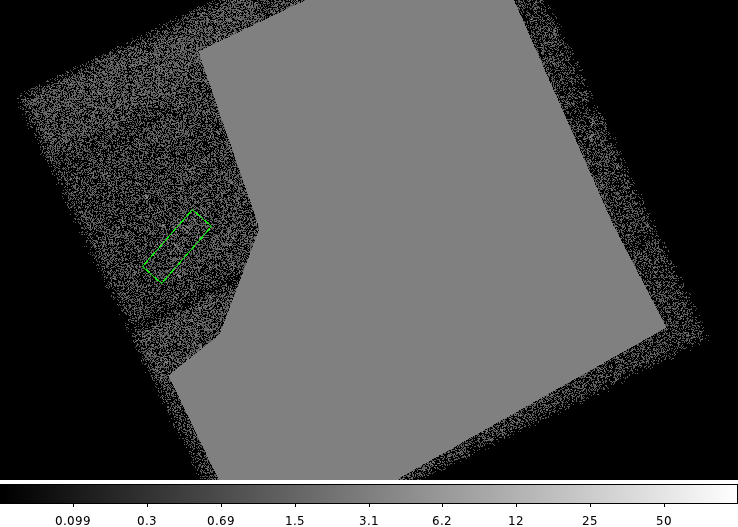

In [74]:
ds9 repair_and_filter_evt2.fits -bin to 4 -scale log -scale limits 0 100 \
 -regions command "physical;${skyreg}" \
 -regions command "${hiddenreg}" \
 -saveimage ds9_13_repair_and_filter_evt_sky.png -quit

display < ds9_13_repair_and_filter_evt_sky.png 

Great.  The anomaly region looks clean.

## Are we done?

Not really.  Remember this:


In [75]:
summarize_status_bits "${repair_evt}[ccd_id=${ccd_id}][(chipx,chipy)=region(evt_mask.reg)]"


BitName    Bit  NumEvt   %Evt  BitDesc
-------    ---  ------   ----  -------
BADLM        1  925819   99.9  Center pixel PHA not local maximum
BADPIX       4   17879    1.9  Center of event island falls on bad pixel
BADPIXE      5   53621    5.8  Surrounding event island falls on bad pixel
GLOW        16  142844   15.4  Event is part of a cosmic ray afterglow


Consider the `BADLM` events.

We have removed 925,819 events because the center pixel in the 3x3 event island was not the maximum pixel anymore after bias correction.  

The thing is, when we detected events at these location, we **cannot** have detected event in the neighboring pixels.  The center of the event island must be _the_ local maximum.

By repairing the bias, we've removed those bad-events; however, because those bad events prohibited any real events in the 3x3 neighborhood around them from ever being detected.  

The problem is that this loss is not accounted for anywhere.  Eg, not in the bad pixel file.

How may neighboring events did we loose?  There's no way to know.   Given what's been done, there is no way to account for this partial loss in the responses (ARF and exposure map).  The response in those regions will higher than they should be and thus the fluxes will be lower.


If the data we taken in `VFAINT` mode (5x5) then _in principle_ we could  look for valid 3x3 events in the 5x5 island.  We do not have any tools to do this. This may provide some sense of the scale of the loss.  But, it's moot since these are `FAINT` mode data.

In [76]:
dmkeypar repair_evt2.fits READMODE echo+
dmkeypar repair_evt2.fits DATAMODE echo+

TIMED
FAINT


## Summary

We have investigated the origin of the anomaly in OBS_ID 21842.  We've identified the pixels in the bias image which are anomalously low.  This resulted in a large number of events being detected.  The low bias value were automatically identified as bad by `acis_build_badpix` and those events were removed when the Level 2 event file was created.

We then emulated the bias repair process where we replaced the low bias values with the local median value and reprocessed the data.

We then investigated the reason for residual anomalous events in the reprocessed Level 2 event file.  They have `PHA_RO` values less than the standard on-orbit event threshold (`38`).  We do not check the event threshold in `acis_process_events`. 


## Recommendation

Given the uncertainty in the efficiency of the event detection in the repaired anomaly region I would suggest we abandon the bias repair version.  We can recover a few events but we don't know what the ARF or exposure map is appropriate for them.

I thought that there was an Applicability clause in the [original ECR](http://icxc.harvard.edu/po/ccb/ecr10/cxc-2010-010.pdf).  However, upon review it lacks any specific criteria for when the bias repair can be applied.
Well, it does say the bias repair won't be done unless the feature is more than `20` columns wide.  That's not the case here -- it's a single pixel wide (but since its oriented at an angle to the readout it spans more than 20 columns).
I also suggest this be reviewed.  If the bias repair involves changes in the bias level of more than $\pm$6ADU then we will be in this situation again. 

## Stepping off my soap box

Alright, the sermon is served; now to have an objective moment.  

In our current processing, we are indeed making an assumption; an assumption that is unchallenged.  There could be single bit type errors in the bias image we decom on the ground that leads to this kind of situation.
In general, yes, we should challenge our assumptions. It would not be unreasonable to request an additional check be added to `acis_process_events` to compare the `PHA_RO` to the event threshold values.  Given the current status bit definitions, we should designate a new bit in the event file status word.  Not unreasonable and feasible.

The devil is in the details.  What do we mean by 

> the event threshold

?  We have the values in the CALDB; however, there is no guarantee that those were the values used on orbit -- again an unchallenged assumption.  We could use the values in the parameter block files `pbk0`.  But what if those files are corrupted?  It's unlikely that both the `bias0` and the `pbk0` files would both experience telemetry corruption, 
and even less in a consistent way.  But we don't know for sure if there is an error if it's in the bias or if it's in the pbk.  We don't have access in the L1 pipeline to the parameters of the "as planned" SI-mode though presumably in coordination with the ACIS team some kind of interface could be developed (we'd need to keep in mind CIAO user reprocessing their data here.) 

But wait -- there's more.  Is it even the pbk0 value we should be checking?  A window, `win0` files, can be used which restricts the PHA range of telemetered events.  We would really want to check against those values.  This also now gives an upper PHA limit, not just the lower limit.  I'd think still one status bit ("out of range" rather than "below").

Note: Even with this new bit, my original recommendation stands.  For this specific case, I think reparing the bias does more harm then good.